In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math


In [3]:
train_data_raw =  pd.read_csv("Gasleak Data Sets/sensor_readings.csv")
train_data_raw.columns = ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [4]:
test_data_raw = pd.read_csv("Gasleak Data Sets/validation_files/sensor_readings.csv")
test_data_raw.columns =  ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [5]:
leak_data_raw = pd.concat([train_data_raw, test_data_raw], ignore_index=True)
leak_data = leak_data_raw.copy()
leak_data = leak_data.iloc[3000:7000]
leak_data = leak_data.reset_index()
leak_data = leak_data.drop(['temp','index'], axis=1)
leak_data['Sum'] = leak_data.iloc[:,1:].sum(axis=1)
leak_data['Mean'] = leak_data.iloc[:,1:-1].mean(axis=1)

In [6]:
def MinMax(X, col):
    return (X - col.min()) / (col.max() - col.min())
def invMinMax(X_scaled, col):
    X = X_scaled * (col.max() - col.min()) + col.min()
    return X

In [7]:
leak_data['Normalized Sensor 1'] = MinMax(leak_data['Sensor 1'], leak_data['Sensor 1'])

In [8]:
def load_data(feature, look_back):
    data_raw = feature.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
feature =  leak_data[['Normalized Sensor 1']]


x_train, y_train, x_test, y_test = load_data(feature, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3152, 59, 1)
y_train.shape =  (3152, 1)
x_test.shape =  (788, 59, 1)
y_test.shape =  (788, 1)


In [9]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
import model as m

input_dim = 1
hidden_dim = 16
num_layers = 2 
output_dim = 1

model = m.LSTM(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)

# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
10
torch.Size([64, 1])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([1, 16])
torch.Size([1])


In [11]:
import os

# Train model
num_epochs = 300
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back - 1

# Set the checkpoint parameters
checkpoint_dir = "sensor_checkpoints"  # Directory to save checkpoints
checkpoint_interval = 10  # Save a checkpoint every 10 epochs
start_epoch = 0  # Start from this epoch (useful for resuming training)

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Load the model state from a checkpoint (if available)
checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{start_epoch}.pth"
if start_epoch > 0 and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimiser.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")

for t in range(start_epoch, num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)


    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    # Save a checkpoint
    if (t + 1) % checkpoint_interval == 0:
        checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{t}.pth"
        torch.save({
            "epoch": t,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimiser.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {t}")

Checkpoint saved for epoch 9
Epoch  10 MAE:  0.10025222599506378
Checkpoint saved for epoch 19
Epoch  20 MAE:  0.09661148488521576
Checkpoint saved for epoch 29
Epoch  30 MAE:  0.09132533520460129
Checkpoint saved for epoch 39
Epoch  40 MAE:  0.07789450883865356
Checkpoint saved for epoch 49
Epoch  50 MAE:  0.06214572861790657
Checkpoint saved for epoch 59
Epoch  60 MAE:  0.049378037452697754
Checkpoint saved for epoch 69
Epoch  70 MAE:  0.04175238311290741
Checkpoint saved for epoch 79
Epoch  80 MAE:  0.03774533420801163
Checkpoint saved for epoch 89
Epoch  90 MAE:  0.03365865349769592
Checkpoint saved for epoch 99
Epoch  100 MAE:  0.02959495782852173
Checkpoint saved for epoch 109
Epoch  110 MAE:  0.026633664965629578
Checkpoint saved for epoch 119
Epoch  120 MAE:  0.024135911837220192
Checkpoint saved for epoch 129
Epoch  130 MAE:  0.024626852944493294
Checkpoint saved for epoch 139
Epoch  140 MAE:  0.022060006856918335
Checkpoint saved for epoch 149
Epoch  150 MAE:  0.0232892185449

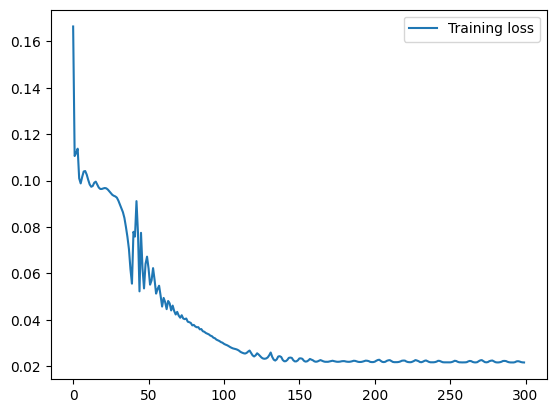

In [12]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [13]:
np.mean((y_train_pred.detach().numpy()-y_train.detach().numpy()) ** 2)

0.0014245017

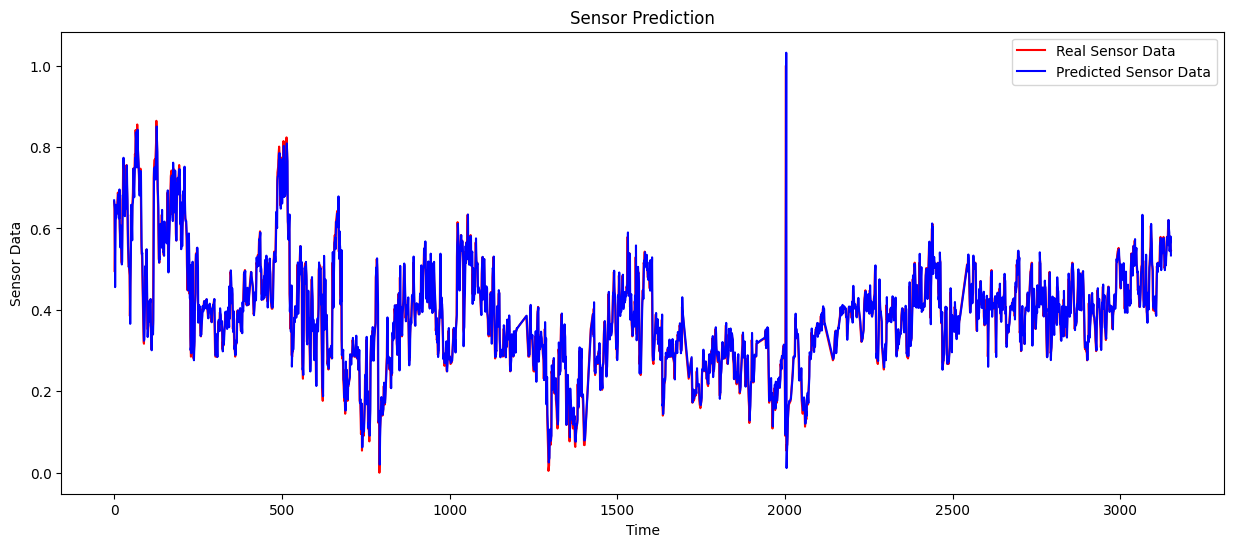

In [14]:
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot( y_train.detach().numpy(), color = 'red', label = 'Real Sensor Data')
axes.plot( y_train_pred.detach().numpy(), color = 'blue', label = 'Predicted Sensor Data')
plt.title('Sensor Prediction')
plt.xlabel('Time')
plt.ylabel('Sensor Data')
plt.legend()
plt.savefig('Sensor Prediction vs Real (Train).png')

plt.show()

In [15]:
# %%
# make predictions
y_test_pred = model(x_test)

# # Implement transform
# # invert predictions
y_train_pred = (y_train_pred.detach().numpy())
y_train = (y_train.detach().numpy())
y_test_pred = (y_test_pred.detach().numpy())
y_test = (y_test.detach().numpy())


# invert predictions
y_train_pred = invMinMax(y_train_pred, leak_data['Sensor 1'])
y_train = invMinMax(y_train, leak_data['Sensor 1'])
y_test_pred = invMinMax(y_test_pred, leak_data['Sensor 1'])
y_test = invMinMax(y_test, leak_data['Sensor 1'])


y_test_pred = y_test_pred
print(type(y_train))



# calculate  mean absolute error
print(y_train[:,0], y_train_pred[:,0])
trainScore = (mean_absolute_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f MAE' % (trainScore))
testScore =(mean_absolute_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAE' % (testScore))


<class 'numpy.ndarray'>
[1002.   999.   964.  ...  983.   975.   975.5] [1002.82166 1000.5836   997.821   ...  980.2816   983.19604  972.9292 ]
Train Score: 4.76 MAE
Test Score: 4.07 MAE


In [16]:
# figure, axes = plt.subplots(figsize=(15, 6))

# axes.plot( y_test, color = 'red', label = 'Real Sensor Data')
# axes.plot( y_test_pred, color = 'blue', label = 'Predicted Sensor Data')
# plt.title('Sensor Prediction')
# plt.xlabel('Time')
# plt.ylabel('Sensor Data')
# plt.legend()
# plt.savefig('Sensor Prediction vs Real (Test)')

# plt.show()

In [17]:
pd.DataFrame(y_test_pred).to_csv('y_test_pred.csv', index=False)

/var/folders/qt/r87857tx74n48x9wj7f9wljw0000gn/T/ipykernel_21785/1629767436.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15, 6))


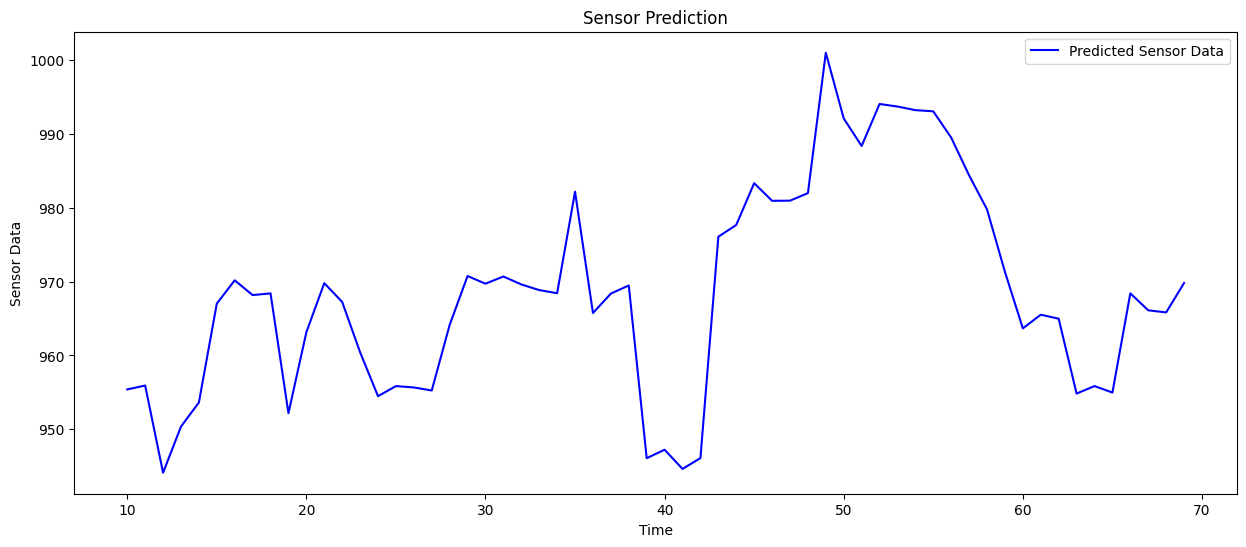

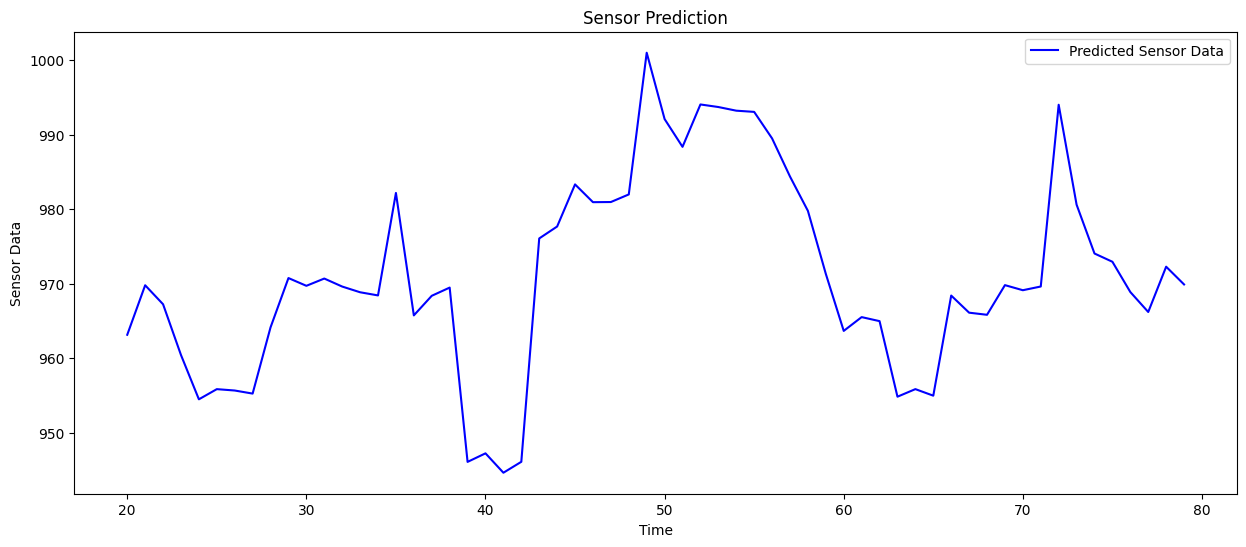

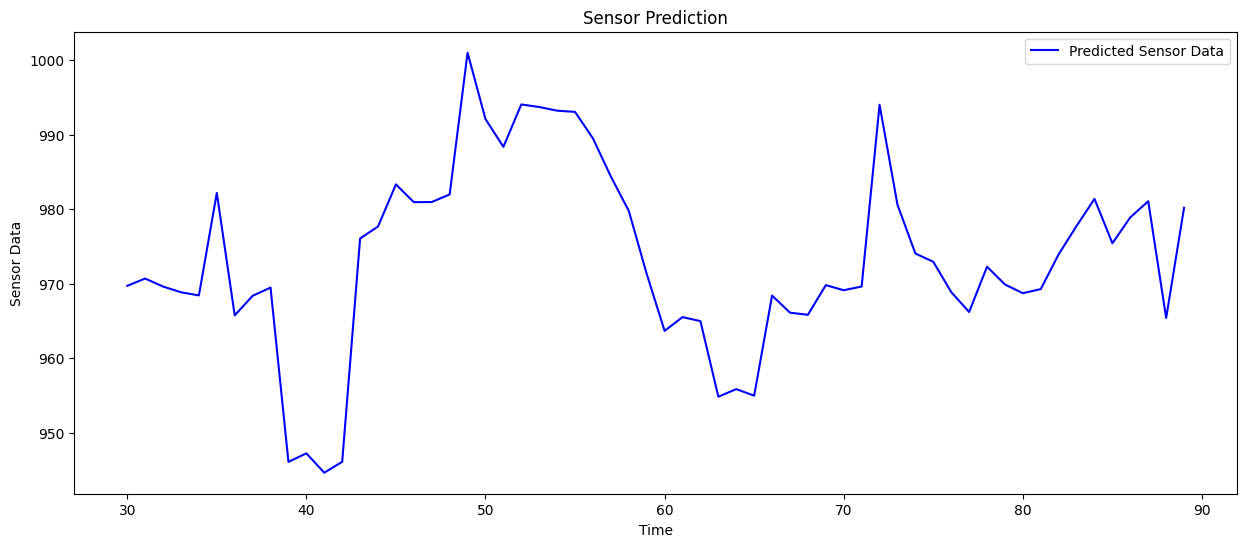

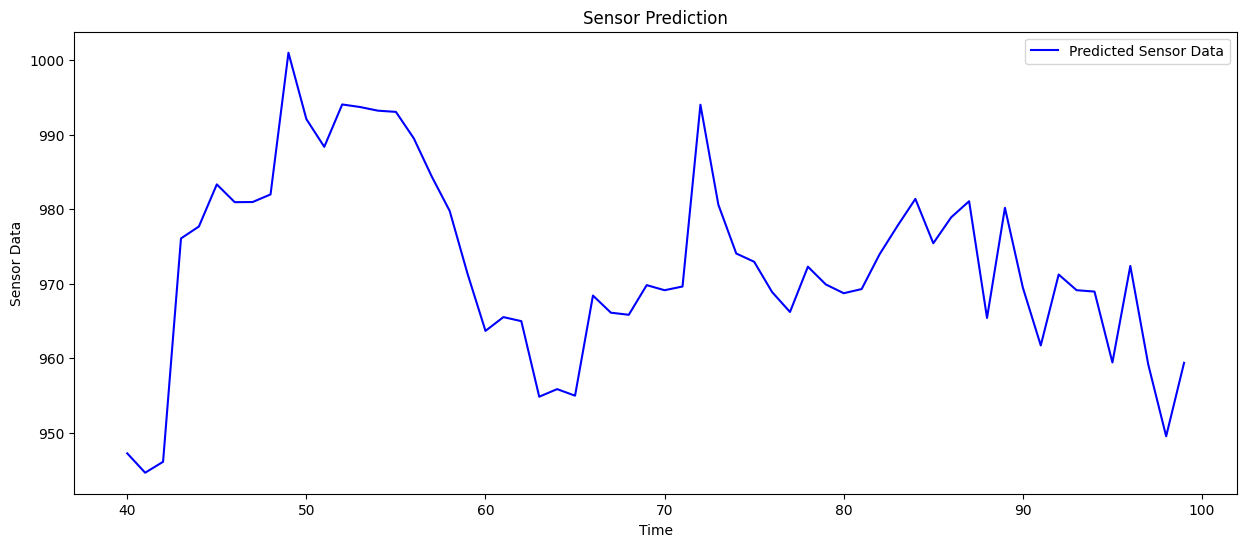

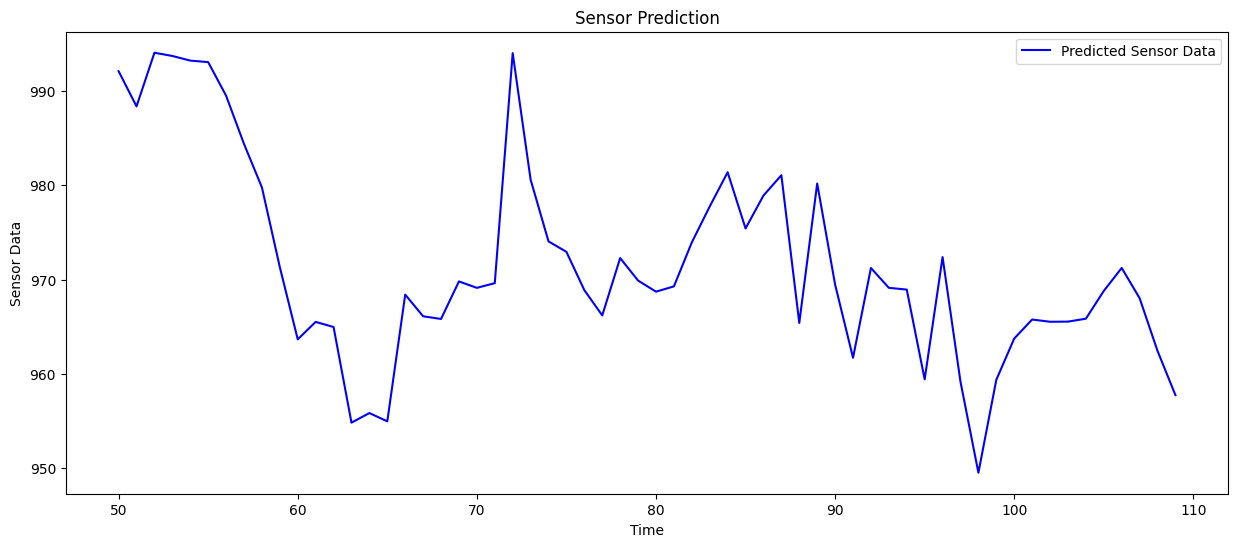

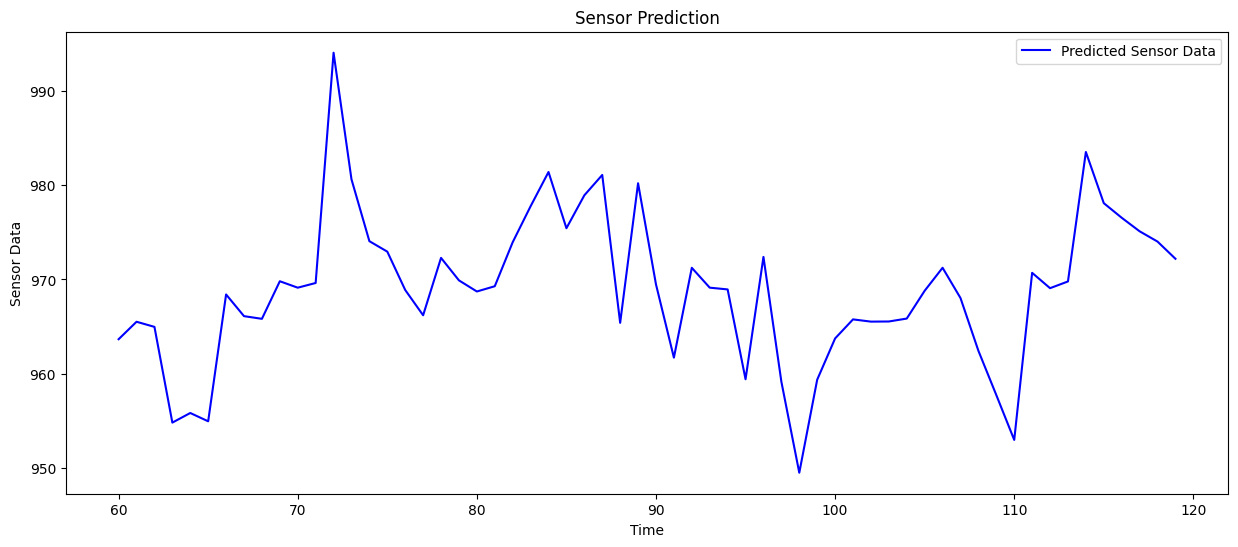

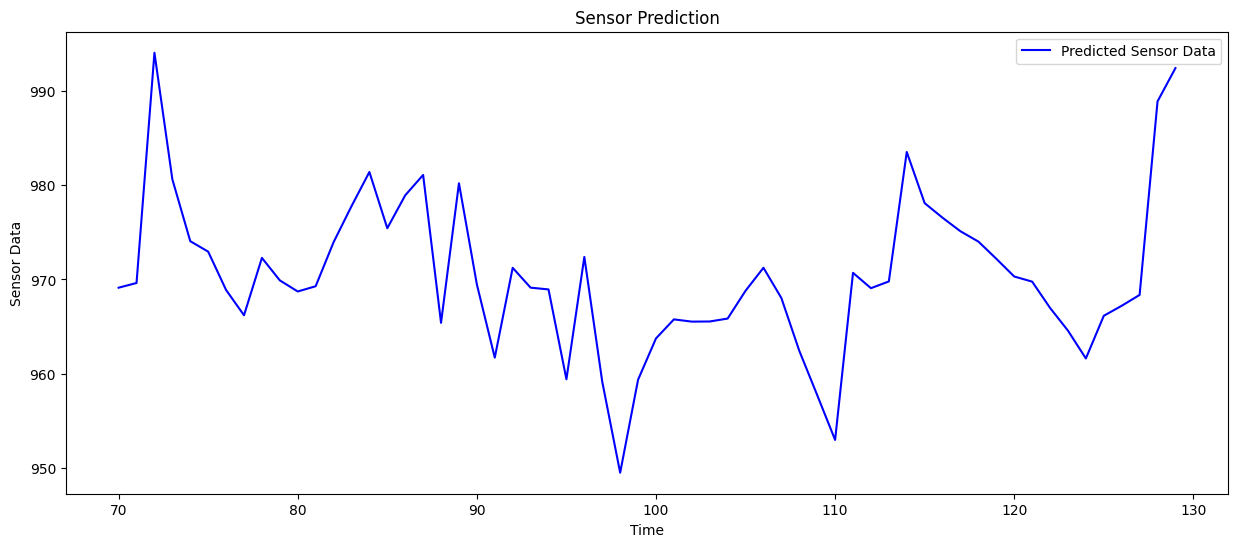

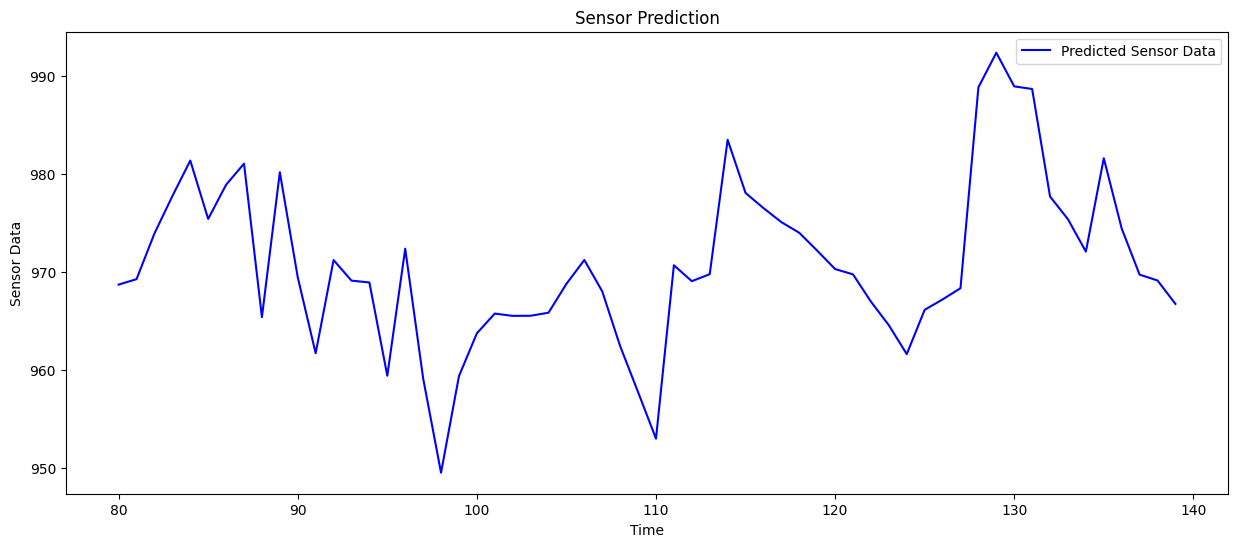

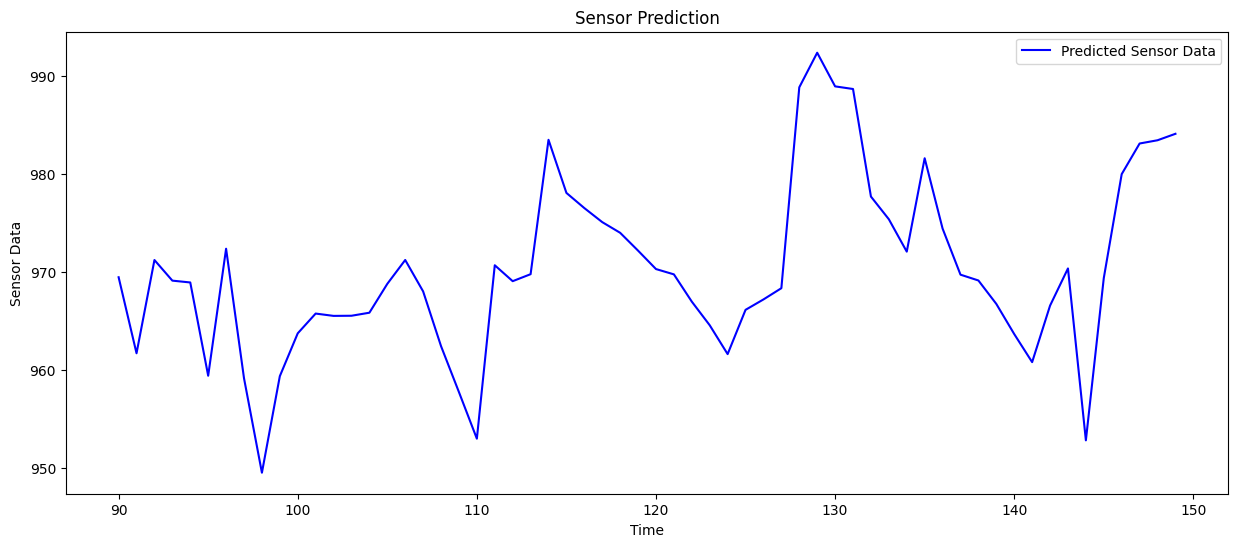

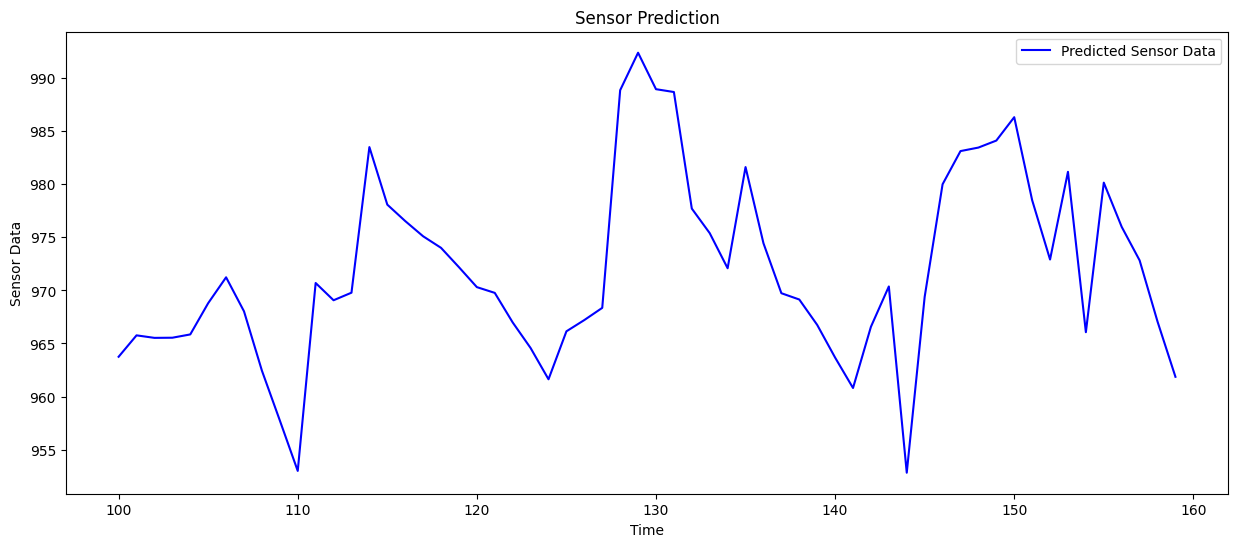

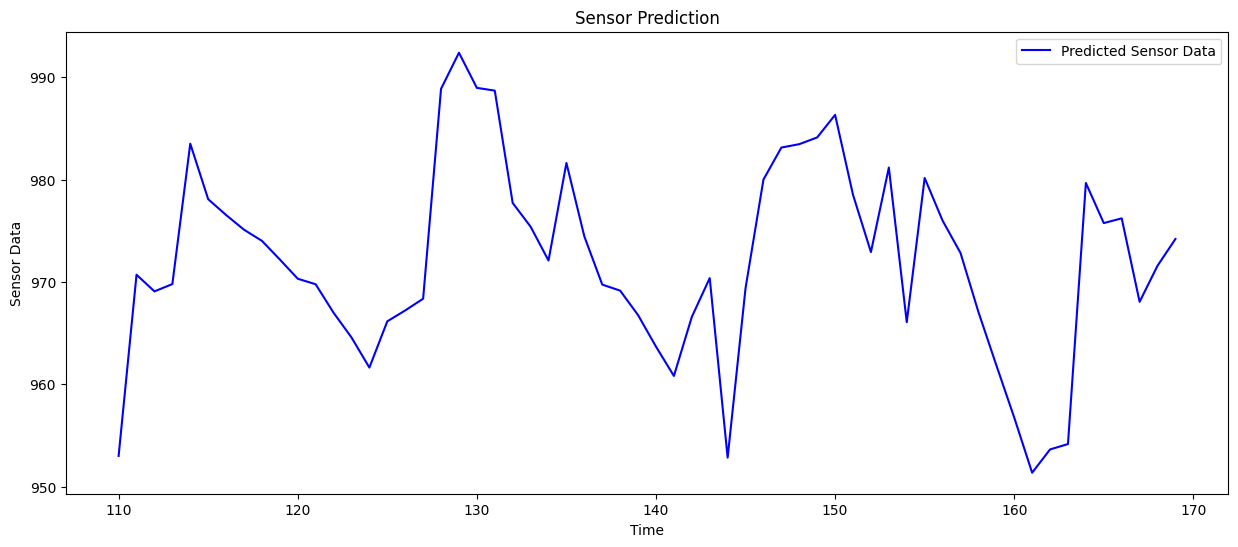

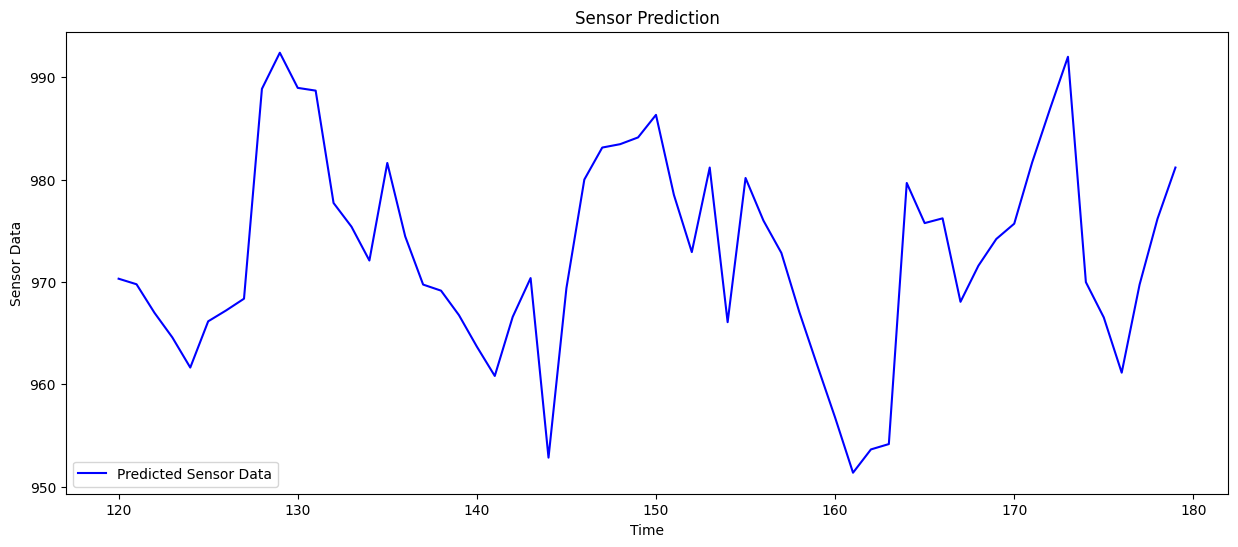

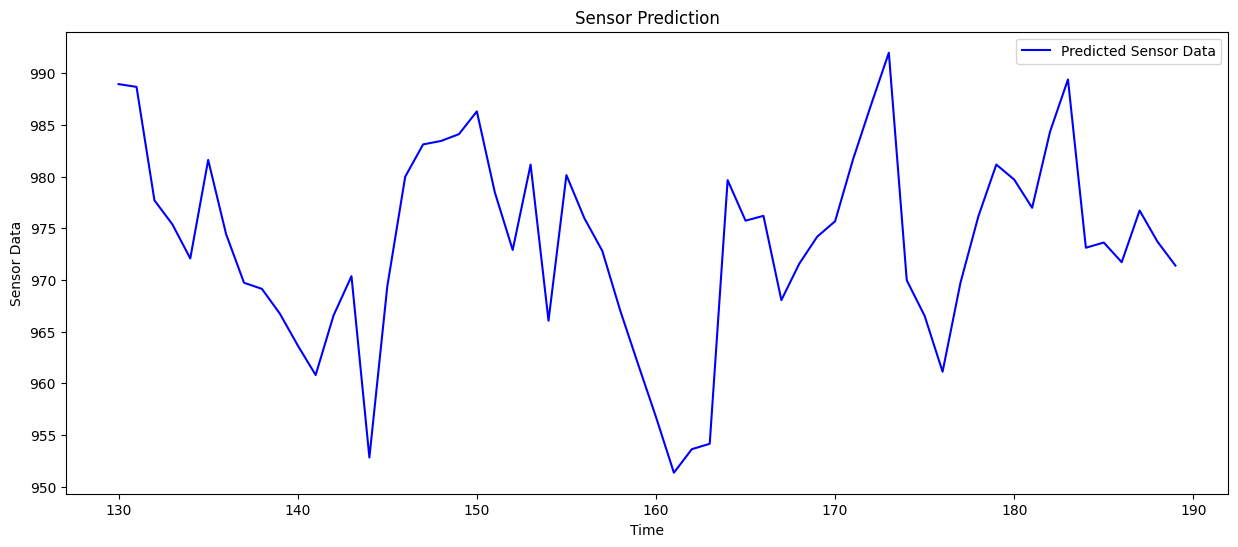

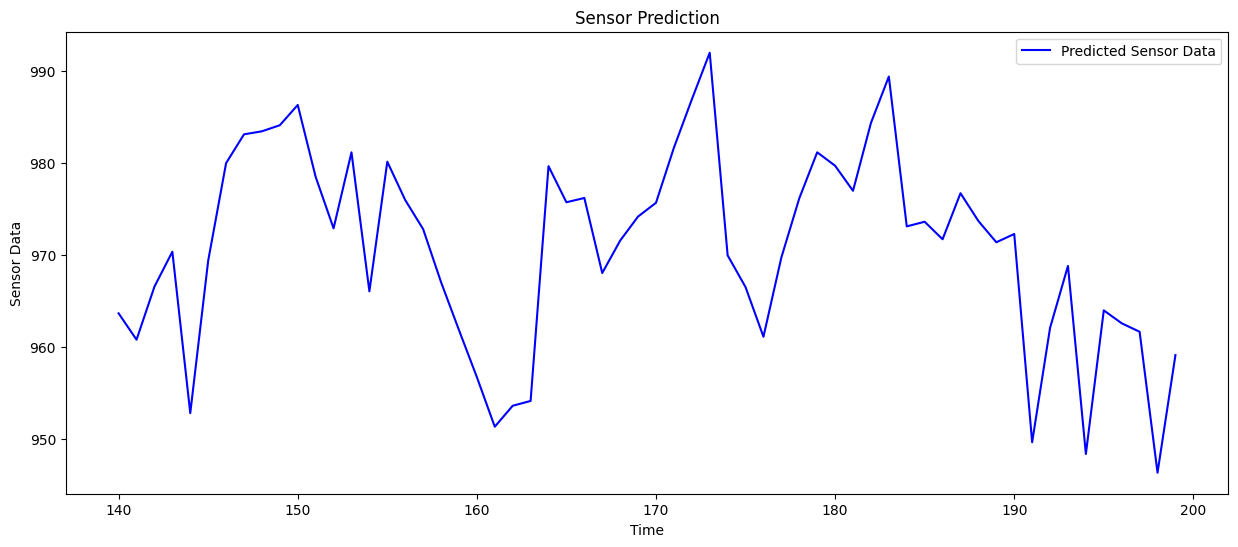

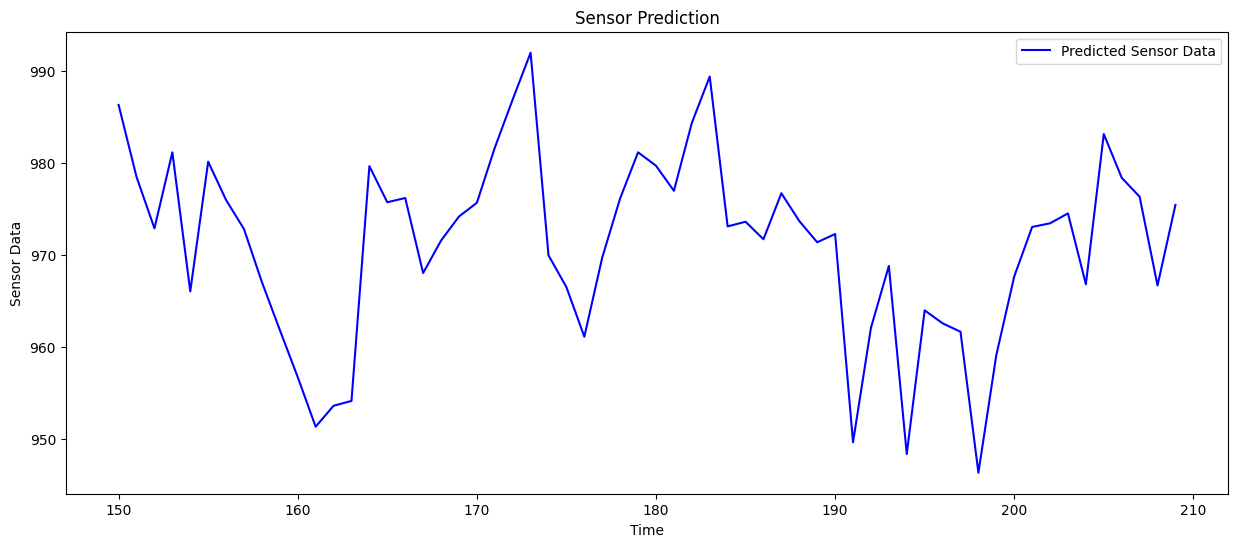

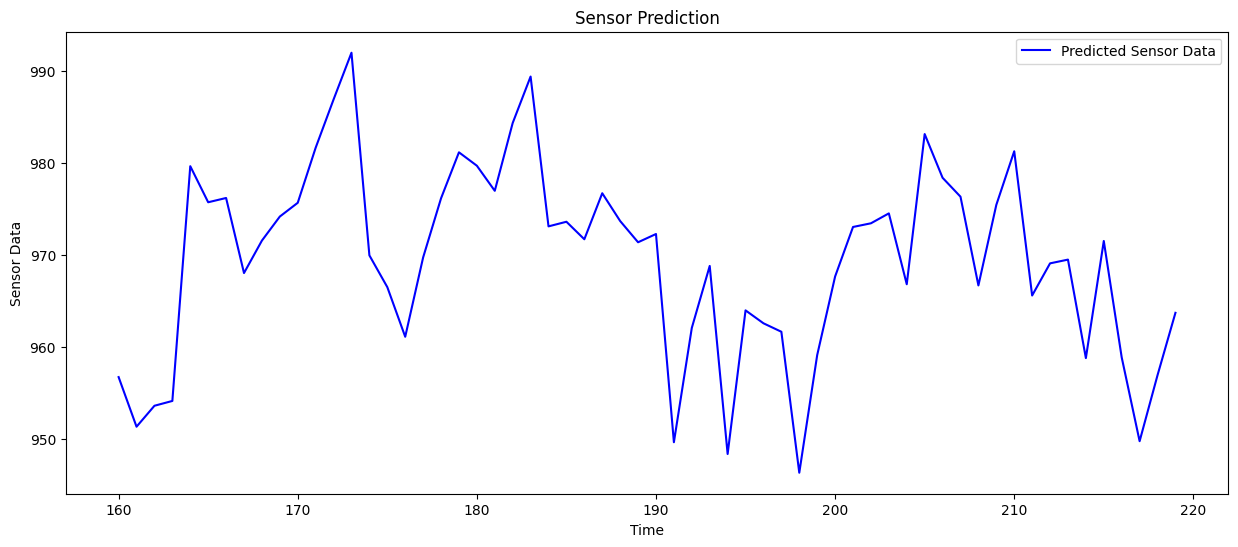

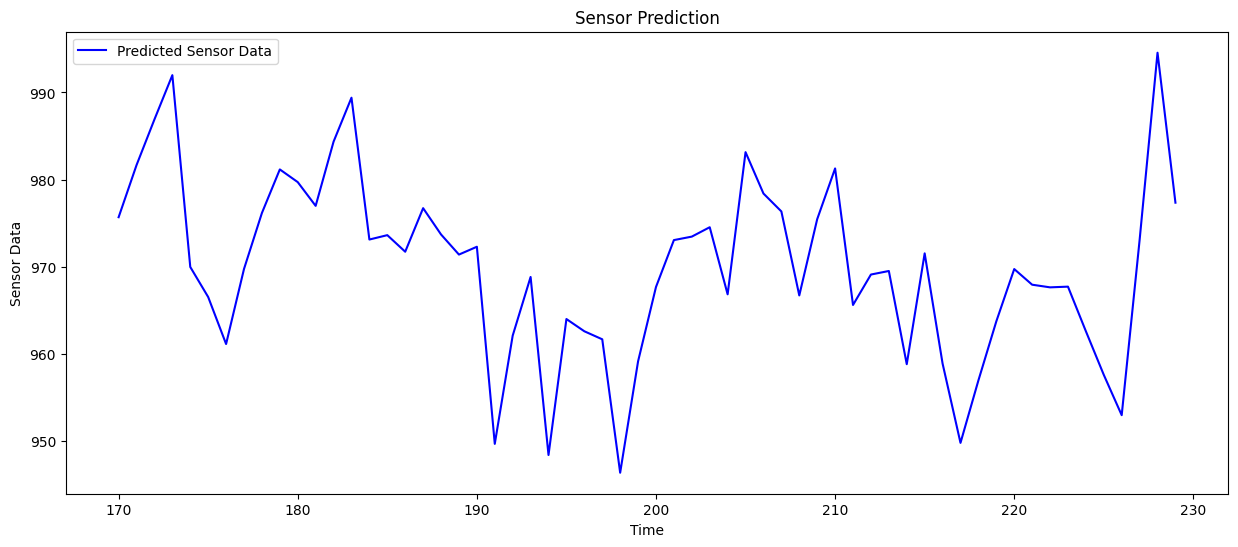

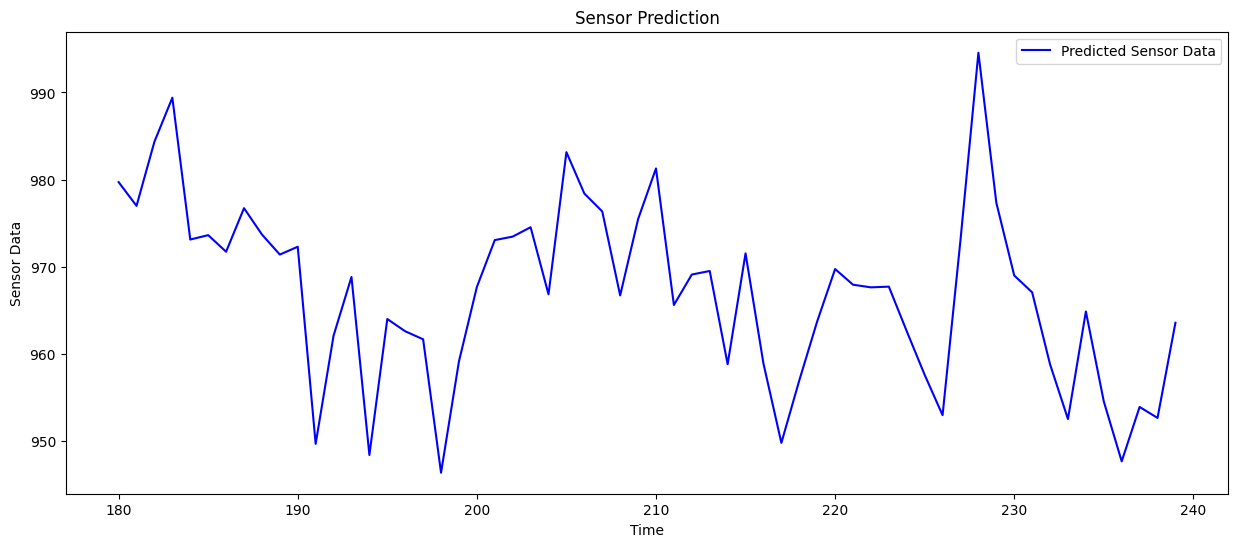

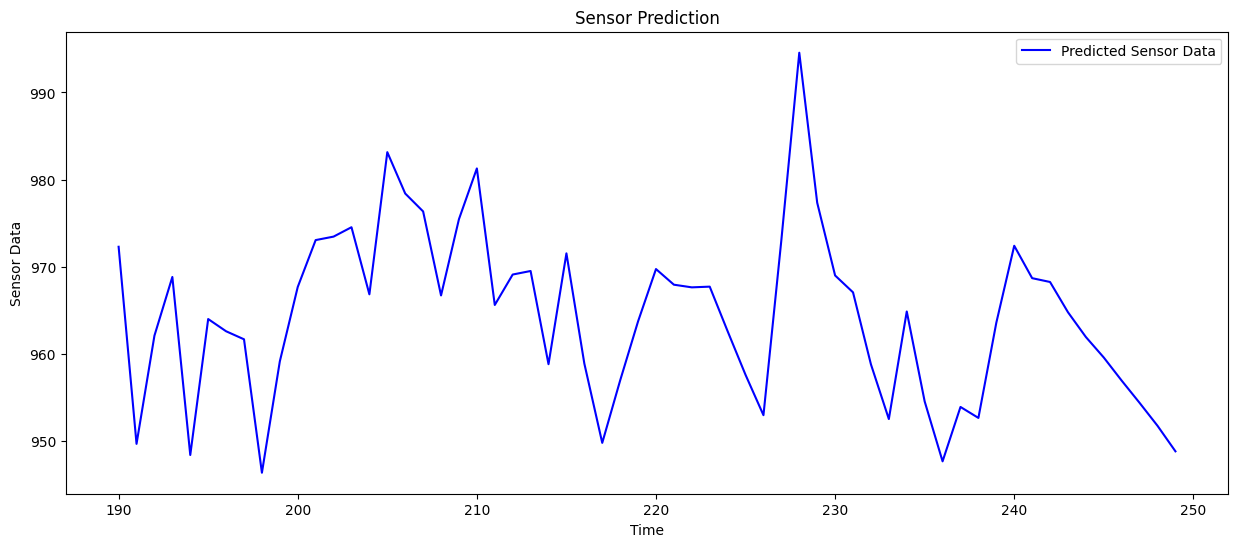

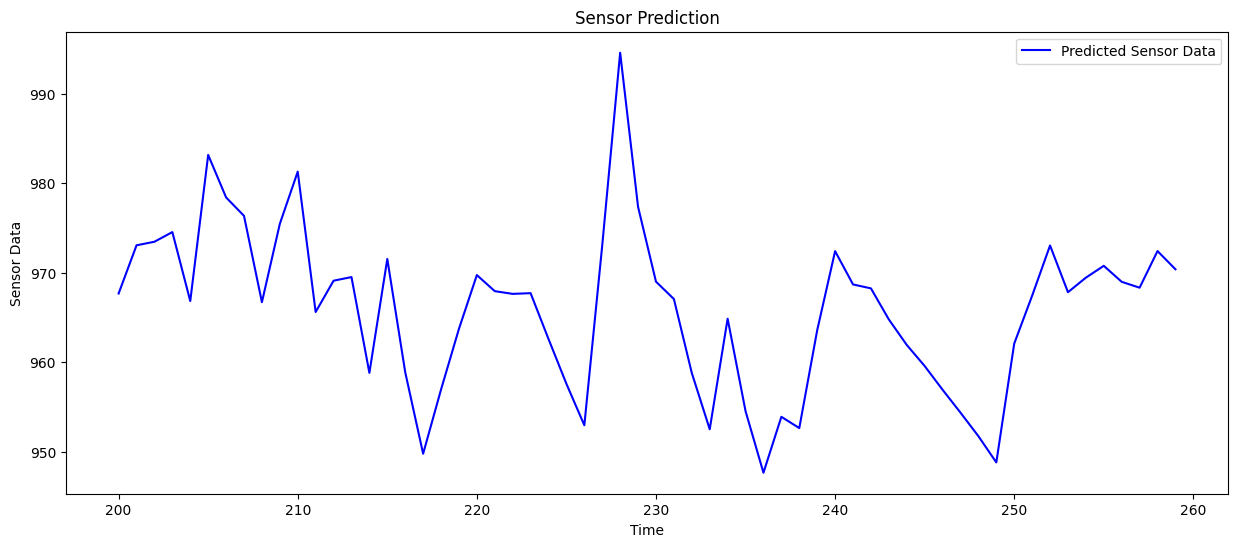

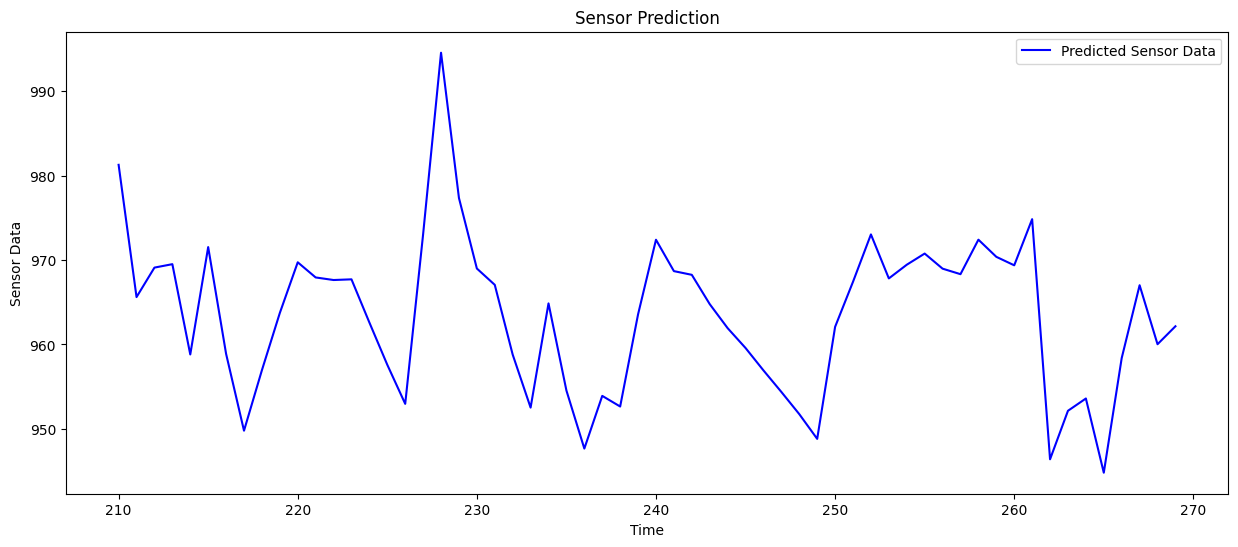

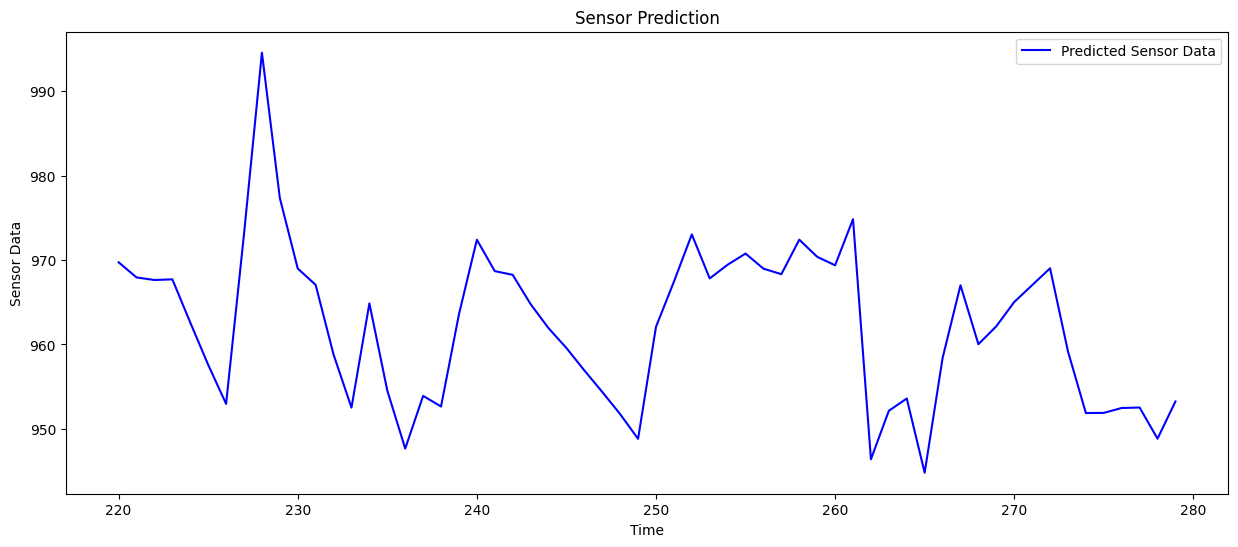

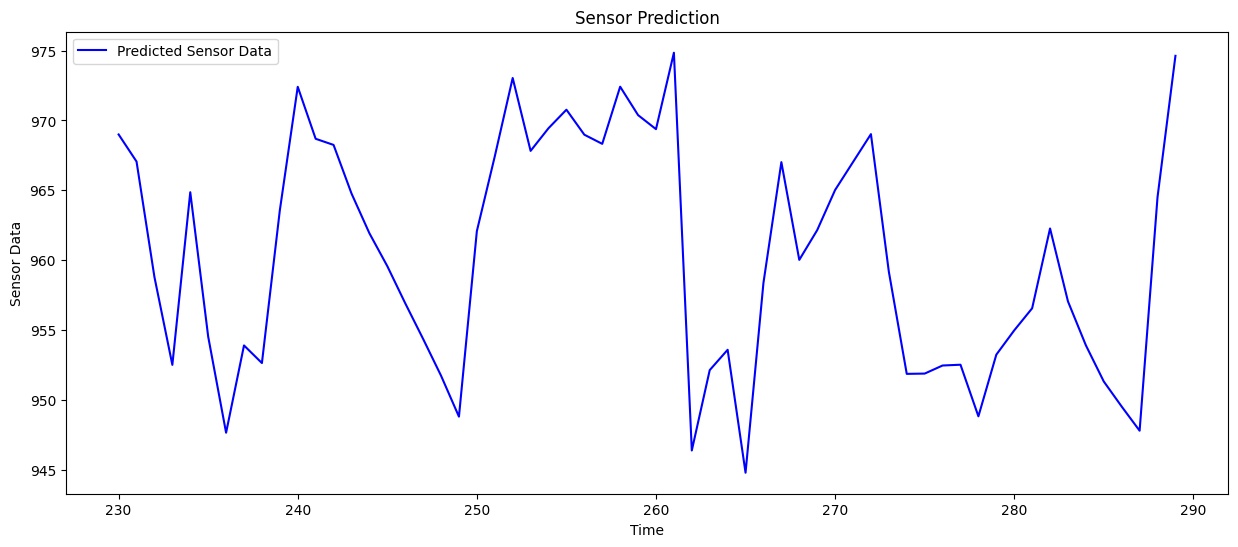

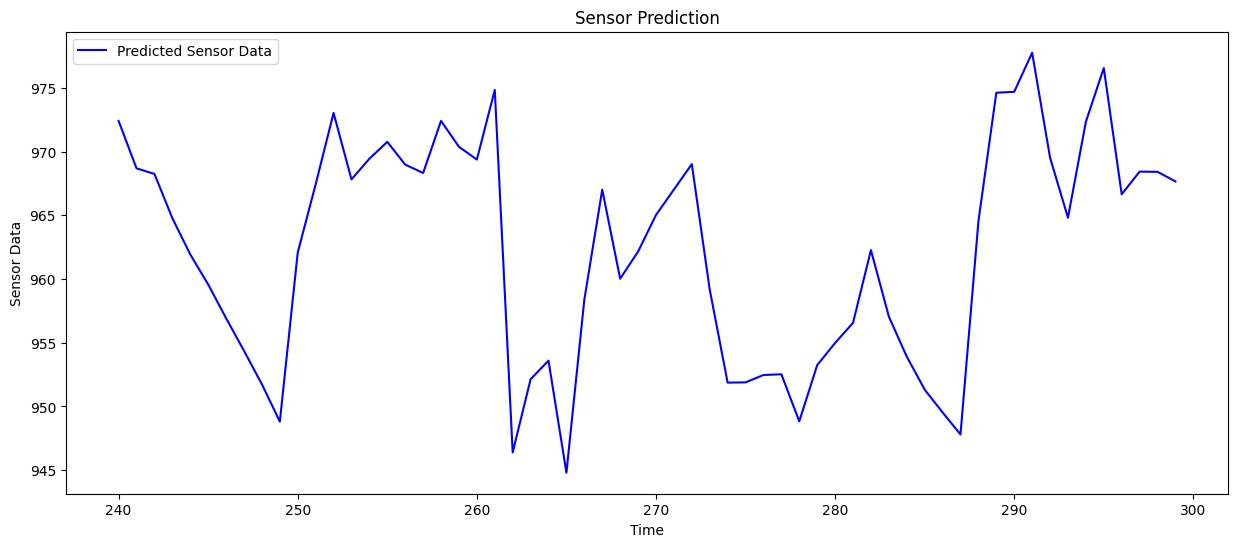

In [24]:
def plot_sensor_data(y_test_pred, index):
    index  *= 10
    tEnd =  index + 60

    directory = 'Sensor_Graphs'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = os.path.join(directory, f'prediction_v_time{index/10}.png')

    y_test_pred = y_test_pred[index:tEnd]
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(y_test_pred, color='blue', label='Predicted Sensor Data')
    ax.set_title('Sensor Prediction')
    ax.set_xlabel('Time')
    ax.set_ylabel('Sensor Data')
    ax.legend()

    plt.savefig(filename)

    # return fig

# plot_sensor_data(y_test_pred=pd.read_csv('y_test_pred.csv'),index=4)

for i in range(1,25):
    plot_sensor_data(y_test_pred=pd.read_csv('y_test_pred.csv'),index=i)
    

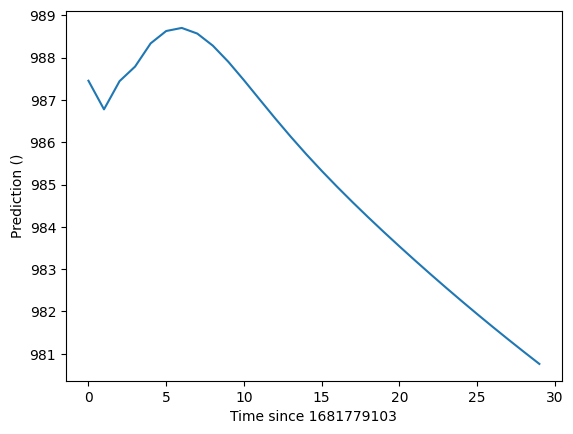

In [19]:
def get_prediction(startTime, time_after):

    directory = f'Sensor_Graphs'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = os.path.join(directory, f'prediction_v_time{startTime}_to_{startTime+time_after}.png')

    plt.xlabel(f"Time since {startTime}")
    plt.ylabel("Prediction ()")

    startTime -= leak_data.loc[0,'Time']
    current = leak_data[['Normalized Sensor 1']].iloc[startTime-look_back : startTime].to_numpy()
    current = torch.tensor(current, dtype=torch.float32)
    current = current.reshape(1, len(current), 1)

    predictions = []
    for _ in range(time_after):
        pred = model(current).detach()
        predictions.append(pred.squeeze().item())
        current = torch.cat((current[:, 1:, :], pred.unsqueeze(1)), dim=1)

    predictions = invMinMax(torch.tensor(predictions), leak_data['Sensor 1'])

    plt.plot(predictions)
    plt.savefig(filename)

    plt.show()
    

get_prediction(1681779103,30)